# Covid-19 Vaccination Campaign in Germany

The data used here were provided by 
[Robert Koch Institute](https://www.rki.de) and the [German federal ministry of Health](https://www.bundesgesundheitsministerium.de/).

These institutions publish the datasets and some analysis on the page [impfdashboard.de](https://impfdashboard.de/).

## Setup

### Imports

In [141]:
# standard library
import datetime
import math

In [142]:
# third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

### Date this Notebook was run

In [143]:
today = datetime.datetime.today().strftime('%Y-%m-%d')
today

'2021-04-18'

### Set Defaults

In [144]:
# style like ggplot in R
plt.style.use('ggplot')

## Get and Transform Data

In [145]:
vaccination_data_permalink = 'https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv'
vaccinations = pd.read_csv(
    vaccination_data_permalink,
    sep="\t")

### Drop unnecessary columns

Columns with names starting with 'indikation_' will not be analyzed as the data providers stopped updating them.

In [146]:
# No analysis of indication planned:
cols_to_drop = vaccinations.columns[vaccinations.columns.str.contains('indikation_')]
vaccinations.drop(columns=cols_to_drop, inplace=True)

In [147]:
# Convert datatype of date column
vaccinations.iloc[ : , [0]] = vaccinations.iloc[ : , [0]].apply(pd.to_datetime)

### Show Data

In [148]:
vaccinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   date                              111 non-null    datetime64[ns]
 1   dosen_kumulativ                   111 non-null    int64         
 2   dosen_differenz_zum_vortag        111 non-null    int64         
 3   dosen_erst_differenz_zum_vortag   111 non-null    int64         
 4   dosen_zweit_differenz_zum_vortag  111 non-null    int64         
 5   dosen_biontech_kumulativ          111 non-null    int64         
 6   dosen_moderna_kumulativ           111 non-null    int64         
 7   dosen_astrazeneca_kumulativ       111 non-null    int64         
 8   personen_erst_kumulativ           111 non-null    int64         
 9   personen_voll_kumulativ           111 non-null    int64         
 10  impf_quote_erst                   111 non-null    

In [149]:
vaccinations.tail(3)

,date,dosen_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_biontech_kumulativ,dosen_moderna_kumulativ,dosen_astrazeneca_kumulativ,personen_erst_kumulativ,personen_voll_kumulativ,impf_quote_erst,impf_quote_voll
108,2021-04-14,20108105,767050,685188,81862,14895847,1068764,4143494,14819917,5288188,0.178,0.064
109,2021-04-15,20772375,664270,596361,67909,15417625,1103466,4251284,15416278,5356097,0.185,0.064
110,2021-04-16,21332342,559967,490074,69893,15831067,1130287,4370988,15906352,5425990,0.191,0.065


### Last Update

Often the data is not updated on weekends, so get the highest date in the dataset.

In [150]:
last_update = vaccinations.loc[vaccinations.index[-1], "date"].strftime('%Y-%m-%d')

## Doses Used

In [151]:
doses = vaccinations.loc[ : , ['date', 'dosen_differenz_zum_vortag']]
# Rename columns
doses.columns = ['date', 'doses used']

In [152]:
# Scale number of doses as millions
doses['doses used'] = doses['doses used'] / 1_000_000

### Doses Daily

In [153]:
doses_daily = doses.set_index('date', inplace=False)
doses_daily.tail(1)

,doses used
date,
2021-04-16,0.559967


In [154]:
# What is the highest number of doses used in a day?
max_doses_daily = max(doses_daily['doses used'])
max_doses_daily

0.76705

<AxesSubplot:title={'center':'VACCINATION DOSES PER DAY IN GERMANY'}, xlabel='Date', ylabel='Million Doses'>

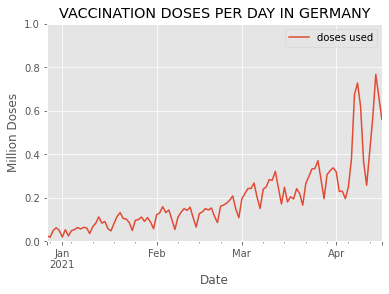

In [155]:
doses_daily.plot(
    ylim=(0,math.ceil(max_doses_daily)),
    xlabel='Date',
    ylabel='Million Doses',
    title='VACCINATION DOSES PER DAY IN GERMANY')

### Doses per Week

In [156]:
# W-Mon in order to start the week on a Monday, see:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#anchored-offsets
doses_weekly = doses.groupby(pd.Grouper(key='date',freq='W-Mon')).sum()
doses_weekly.columns = ['million doses used']
doses_weekly.tail()

,million doses used
date,
2021-03-22,1.470258
2021-03-29,2.120416
2021-04-05,1.885101
2021-04-12,3.433889
2021-04-19,2.558788


In [157]:
# What is the highest number of doses used in a week?
max_million_doses_weekly = max(doses_weekly['million doses used'])
max_million_doses_weekly

3.433889

<AxesSubplot:title={'center':'VACCINATION DOSES PER WEEK IN GERMANY\n(until 2021-04-16)'}, xlabel='Date', ylabel='Million Doses'>

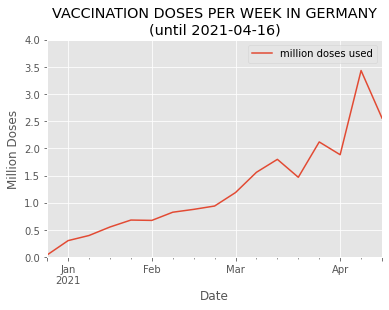

In [158]:
doses_weekly.plot(
    ylim=(0, math.ceil(max_million_doses_weekly)),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER WEEK IN GERMANY\n(until {last_update})")

### Doses per Month

In [159]:
# M = month end frequency
doses_monthly = doses.groupby(pd.Grouper(key='date',freq='M')).sum()
doses_monthly.tail()

,doses used
date,
2020-12-31,0.203328
2021-01-31,2.338412
2021-02-28,3.765226
2021-03-31,7.809576
2021-04-30,7.215800


In [160]:
max_doses_monthly = max(doses_monthly['doses used'])
max_doses_monthly
doses_monthly['month'] = doses_monthly.index.strftime('%B')
doses_monthly['year'] =  doses_monthly.index.strftime('%Y')
doses_monthly['label'] = doses_monthly['month'] + ' ' + doses_monthly['year']
doses_monthly.drop(columns=['month', 'year'], inplace=True)
doses_monthly.set_index('label', inplace=True)
doses_monthly.tail(6)

,doses used
label,
December 2020,0.203328
January 2021,2.338412
February 2021,3.765226
March 2021,7.809576
April 2021,7.215800


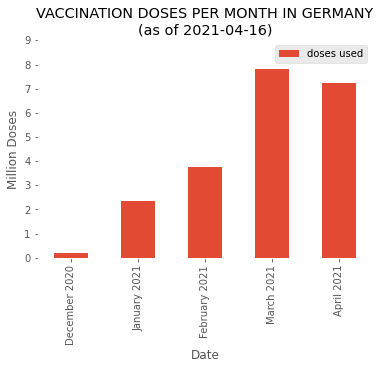

In [161]:
monthly_plot = doses_monthly.plot.bar(
    ylim=(0,math.ceil(max_doses_monthly) + 1),
    xlabel='Date',
    ylabel='Million Doses',
    title=f"VACCINATION DOSES PER MONTH IN GERMANY\n(as of {last_update})")
monthly_plot.set_facecolor('white')

In [162]:
fig = monthly_plot.get_figure()
fig.savefig('img/monthly_doses_germany.png')

## Vaccination Campaign Progress

In [163]:
doses_cumulative = vaccinations.loc[ : , ['date', 'personen_erst_kumulativ', 'personen_voll_kumulativ']]
doses_cumulative.set_index('date', inplace=True)
doses_cumulative.tail(3)

,personen_erst_kumulativ,personen_voll_kumulativ
date,,
2021-04-14,14819917,5288188
2021-04-15,15416278,5356097
2021-04-16,15906352,5425990


In [164]:
population_germany = 83_200_000
# Calculate new fields
doses_cumulative['first vaccination'] = round(
    doses_cumulative['personen_erst_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative['fully vaccinated'] = round(
    doses_cumulative['personen_voll_kumulativ'] * 100 / population_germany,
    2)
doses_cumulative.drop(columns=['personen_erst_kumulativ','personen_voll_kumulativ'], inplace=True)
doses_cumulative.tail(3)

,first vaccination,fully vaccinated
date,,
2021-04-14,17.81,6.36
2021-04-15,18.53,6.44
2021-04-16,19.12,6.52


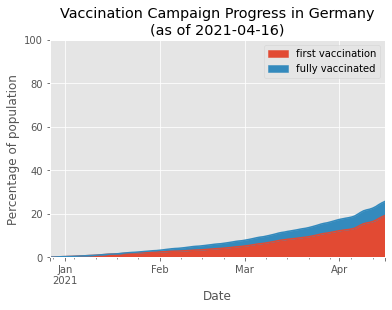

In [165]:
doses_area_plot = doses_cumulative.plot.area(
    ylim=(0,100),
    xlabel='Date',
    ylabel='Percentage of population',
    title=f"Vaccination Campaign Progress in Germany\n(as of {last_update})")

In [166]:
fig = doses_area_plot.get_figure()
fig.savefig('img/vaccinations_germany_area_plot.png')

### As of Today

In [167]:
# get the last line of the data
current_state = doses_cumulative.iloc[-1]
current_state


first vaccination    19.12
fully vaccinated      6.52
Name: 2021-04-16 00:00:00, dtype: float64

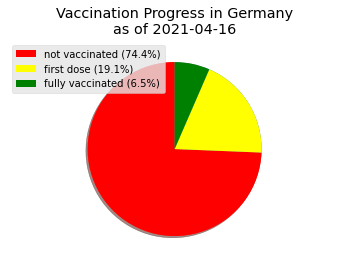

In [168]:
percentage_not_vacc = 100 - current_state['first vaccination'] - current_state['fully vaccinated']
labels = [f"not vaccinated ({round(percentage_not_vacc, 1)}%)",
          f"first dose ({round(current_state['first vaccination'],1)}%)",
          f"fully vaccinated ({round(current_state['fully vaccinated'],1)}%)"]
colors = ['red', 'yellow', 'green']
sizes = [percentage_not_vacc,
         current_state['first vaccination'],
         current_state['fully vaccinated']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.title(f"Vaccination Progress in Germany\nas of {last_update}")
plt.show()

## Vaccines in Use

In [169]:
vaccine_use = vaccinations.loc[ : , ['date', 'dosen_biontech_kumulativ',
                                     'dosen_moderna_kumulativ',
                                     'dosen_astrazeneca_kumulativ']]
# Rename columns
vaccine_use.columns = ['date', 'Biontech', 'Moderna', 'AstraZeneca']
# make 'date' an index
vaccine_use.set_index('date', inplace=True)
# divide columns by 1 million
vaccine_use["Biontech"] = vaccine_use["Biontech"] / 1_000_000
vaccine_use["Moderna"] = vaccine_use["Moderna"] / 1_000_000
vaccine_use["AstraZeneca"] = vaccine_use["AstraZeneca"] / 1_000_000
vaccine_use.tail(3)

,Biontech,Moderna,AstraZeneca
date,,,
2021-04-14,14.895847,1.068764,4.143494
2021-04-15,15.417625,1.103466,4.251284
2021-04-16,15.831067,1.130287,4.370988


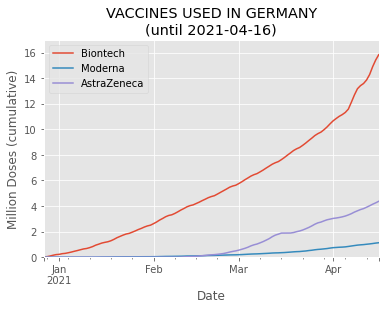

In [170]:
vaccines_used = vaccine_use.plot(
    # as it is cumulative, the last row must contain the single highest number
    ylim=(0,math.ceil(max(vaccine_use.iloc[-1]))+1),
    xlabel='Date',
    ylabel='Million Doses (cumulative)',
    title=f"VACCINES USED IN GERMANY\n(until {last_update})")

In [171]:
fig = vaccines_used.get_figure()
fig.savefig('img/vaccines_used_in_germany.png')